reference:
> Feature Mode Decomposition: New Decomposition Theory for Rotating Machinery
 Fault Diagnosis

Flow diagram of FMD  

1. load raw signal ```x```, Iput decomposed mode number ```n```, filter length ```L```

2. Initialize FIR filter band with ```K``` filters and start iteration ```i=1```

3. Obtain filtered signal or decomposed mode  $u_k^i$   ```Node 3```

4. Period Estimation 
    + compute autocorrelation $R_k^i$ of decomposed mode $u_k^i$
    + find the local maximum value of $R_k^i$ to get estimated periode $T_k^i$



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter, correlate, find_peaks,hilbert
import pandas as pd

In [2]:
FilterSize = 30 # filter length L
CutNum = 7 #the cut number of the whole frequency band
ModeNum = 2 #the final mode number
MaxIterNum = 20 # max iteration number
fs = 2e4 #sampling frequency of x
signal_x = np.array(pd.read_csv("data/3号机组抽水态健康样本.csv",encoding="GBK").iloc[:,1])



In [53]:
class FMD_reconsitution():

    def __init__(self, FilterSize, CutNum,ModeNum,MaxIterNum,fs=None):
        
        self.FilterSize = FilterSize
        self.CutNum= CutNum
        self.ModeNum = ModeNum
        self.MaxIterNum =MaxIterNum
        self.fs = 2e4 if fs ==None else fs

    def initialize_filters(self,L, K):
        
        filters = []
        K = self.CutNum
        eps = np.finfo(float).eps
        freq_bound = np.arange(0, 1, 1 / K)
        L= self.FilterSize
        filters = [
            firwin(FilterSize, [freq_bound[n] + eps, freq_bound[n] + 1 / CutNum - eps],w="hann")
            for n in range(len(freq_bound))
        ]
        
        return filters
    
    def result_initialization(self):
        
        result = pd.DataFrame(
            [[None] * 5 for _ in range(self.CutNum + 1)],
            columns=['IterCount', 'Iterations', 'CorrMatrix', 'ComparedModeNum', 'StopNum']
        )
        
        return result
    
    def update_FIR(self,signal,filters):

        updated_filters = []
        for f in filters:
            period = self.estimate_period(np.convolve(signal, f, mode='same'))
            low_cutoff = max(0, 1 / period - 0.1)
            high_cutoff = min(0.5, 1 / period + 0.1)
            updated_filters.append(firwin(len(f), [low_cutoff, high_cutoff], pass_zero=False, window='hann'))
        
        return updated_filters
   
    def T_estimated(self,signal_x):

        u = np.abs(hilbert(signal_x)) - np.mean(np.abs(hilbert(signal_x)))
        
        return np.argmax(np.correlate(u,u,"full")[int(len(u)//2):])
        # return np.correlate(u,u,"full")[int(len(u)//2):]


    def CK(self,x = None,T = None,M = 2): 

        x = x.flatten()
        N = len(x)

        x_shift = np.zeros((M + 1,N))
        x_shift[0,:] = x

        for m in range(M):
            if T < N: x_shift[m + 1,T+1:] = x_shift[m,:-T-1]
        
        numerator = np.sum(np.prod(x_shift, axis=0)**2)
        denominator = np.sum(x**2)**(M + 1)
        ck = numerator / denominator
        return ck

    def estimate_period(self,x):
        
        signal = x
        correlation = correlate(signal, signal, mode='full')
        correlation = correlation[len(correlation) // 2:]
        peaks, _ = find_peaks(correlation)
        if len(peaks) > 1:
            period = peaks[1]
        else:
            period = len(signal)
        
        return period
    
    def decompose_modes(x, filters):
        modes = []
        for filt in filters:
            # 对信号x应用每个滤波器
            mode = lfilter(filt, [1.0], x)
            modes.append(mode)
        return modes

    def processing(self,signal_x):
        x = signal_x
        if self.FilterSize % 2 == 0:self.FilterSize += 1  
        temp_filters = self.initialize_filters()
        result = self.result_initialization()

        Final_Mode = None
        return Final_Mode

In [54]:
fmd = FMD_reconsitution(
    FilterSize=FilterSize,
    CutNum=CutNum,
    ModeNum=ModeNum,
    fs=None,
    MaxIterNum =MaxIterNum
)

In [43]:
all(x<y for x,y in zip([i for i in range(5)],[i for i in range(1,6)]))

True

# maximum correlated kurtosis deconvolution(mckd)

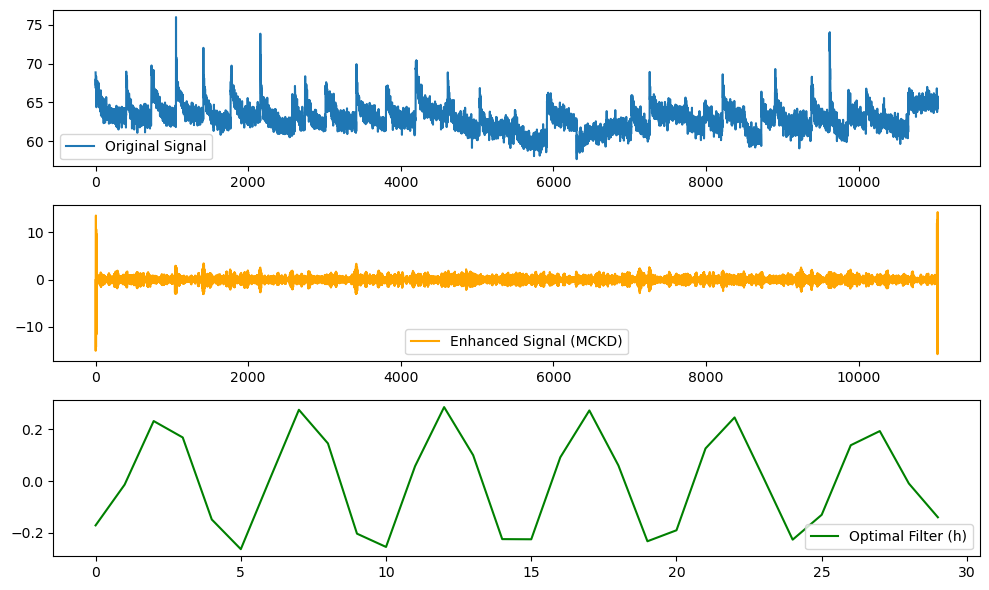

In [44]:
import numpy as np
from scipy.linalg import toeplitz

def mckd(signal, filter_length, delay, iterations=50):
    """
    Perform Maximum Correlated Kurtosis Deconvolution (MCKD).

    Parameters:
        signal (numpy array): The input signal.
        filter_length (int): The length of the FIR filter.
        delay (int): The delay parameter (d).
        iterations (int): Number of iterations for optimization.

    Returns:
        enhanced_signal (numpy array): The deconvolved signal.
        optimal_filter (numpy array): The optimized filter.
    """
    n = len(signal)
    
    # Step 1: Initialize FIR filter
    h = np.zeros(filter_length)
    h[filter_length // 2] = 1  # Start with a simple filter (impulse)
    
    # Step 2: Iterative optimization
    for _ in range(iterations):
        # Construct Toeplitz matrix for current signal
        X = toeplitz(signal, np.zeros(filter_length))
        
        # Compute the deconvolved signal
        y = np.convolve(signal, h, mode='same')
        
        # Compute the delayed signal matrix
        Yd = toeplitz(y[delay:], np.zeros(filter_length))
        
        # Compute covariance matrices
        R0 = X.T @ X
        R1 = Yd.T @ Yd
        
        # Update filter by solving generalized eigenvalue problem
        _, eigvecs = np.linalg.eig(np.linalg.inv(R0) @ R1)
        h = eigvecs[:, 0]  # Use eigenvector corresponding to max eigenvalue
        h /= np.linalg.norm(h)  # Normalize filter
    
    # Step 3: Apply optimized filter to the signal
    enhanced_signal = np.convolve(signal, h, mode='same')
    
    return enhanced_signal, h

# Example usage
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # Generate a test signal with impulses and noise
    np.random.seed(0)
    t = np.linspace(0, 1, 500)
    impulses = np.zeros_like(t)
    impulses[50] = 1
    impulses[200] = 1
    impulses[350] = 1
    noise = 0.5 * np.random.randn(len(t))
    signal = impulses + noise
    signal=signal_x

    # Perform MCKD
    enhanced_signal, optimal_filter = mckd(signal, filter_length=30, delay=10, iterations=50)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.subplot(3, 1, 1)
    plt.plot(signal, label="Original Signal")
    plt.legend()
    
    plt.subplot(3, 1, 2)
    plt.plot(enhanced_signal, label="Enhanced Signal (MCKD)", color='orange')
    plt.legend()
    
    plt.subplot(3, 1, 3)
    plt.plot(optimal_filter, label="Optimal Filter (h)", color='green')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


C:\Users\26921\AppData\Local\Temp\ipykernel_10380\696338600.py:86: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
C:\Users\26921\AppData\Local\Temp\ipykernel_10380\696338600.py:86: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
C:\Users\26921\AppData\Local\Temp\ipykernel_10380\696338600.py:86: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from current font.
  plt.tight_layout()
C:\Users\26921\AppData\Local\Temp\ipykernel_10380\696338600.py:86: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing from current font.
  plt.tight_layout()
C:\Users\26921\AppData\Local\Temp\ipykernel_10380\696338600.py:86: UserWarning: Glyph 22788 (\N{CJK UNIFIED IDEOGRAPH-5904}) missing from current font.
  plt.tight_layout()
C:\Users\26921\AppData\Local\Temp\ipykernel_10380\696338600.py:86: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing fr

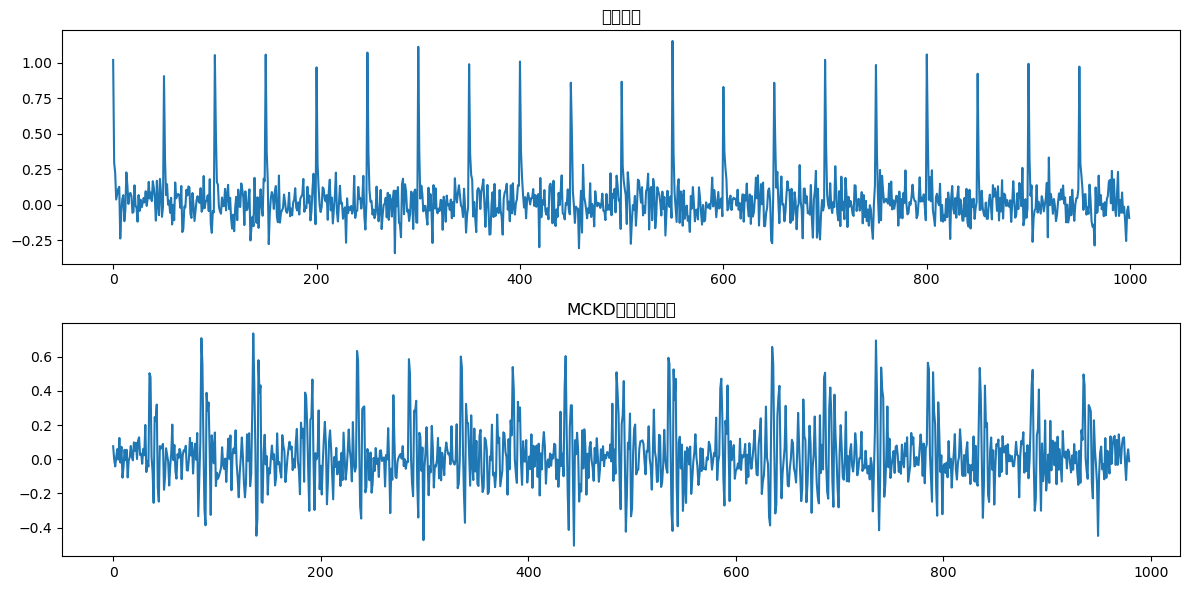

In [1]:
import numpy as np
from scipy import signal

class MCKD:
    def __init__(self, L, T, M=2):
        """
        参数初始化
        L: 滤波器长度
        T: 周期
        M: 移位次数
        """
        self.L = L
        self.T = T
        self.M = M
        self.f = None
    
    def correlated_kurtosis(self, y):
        """计算相关峭度"""
        N = len(y)
        ck = 0
        for n in range(self.M * self.T, N):
            numerator = y[n]
            for m in range(1, self.M + 1):
                numerator *= y[n - m * self.T]
            ck += numerator
        denominator = np.power(np.mean(y**2), self.M + 1)
        return ck / denominator
    
    def design_filter(self, x, max_iter=100, learning_rate=0.1):
        """设计最优滤波器"""
        N = len(x)
        self.f = np.zeros(self.L)
        self.f[self.L//2] = 1  # 初始化滤波器
        
        for _ in range(max_iter):
            # 计算滤波后信号
            y = signal.convolve(x, self.f, mode='valid')
            
            # 计算梯度
            grad = np.zeros(self.L)
            for n in range(self.M * self.T, len(y)):
                temp = y[n]
                for m in range(1, self.M + 1):
                    temp *= y[n - m * self.T]
                
                for l in range(self.L):
                    if n-l >= 0 and n-l < N:
                        grad[l] += temp * x[n-l] / y[n]
            
            # 更新滤波器系数
            self.f += learning_rate * grad
            self.f /= np.linalg.norm(self.f)  # 归一化
    
    def filter(self, x):
        """应用滤波器"""
        if self.f is None:
            raise ValueError("需要先调用design_filter设计滤波器")
        return signal.convolve(x, self.f, mode='valid')

# 使用示例
if __name__ == "__main__":
    # 生成测试信号
    N = 1000
    t = np.linspace(0, 1, N)
    T = 50  # 周期
    # 创建含有周期性冲击的信号
    x = np.random.randn(N) * 0.1
    for i in range(0, N, T):
        if i+5 < N:
            x[i:i+5] += np.exp(-np.arange(5))
    
    # 应用MCKD
    mckd = MCKD(L=21, T=T, M=2)
    mckd.design_filter(x)
    y = mckd.filter(x)
    
    # 绘制结果
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    plt.plot(x)
    plt.title('orginal signal')
    plt.subplot(212)
    plt.plot(y)
    plt.title('MCKD enhanced signal')
    plt.tight_layout()
    plt.show()

![图片](formula\Nomenclature.png)

![图片](formula/12.png)

In [ ]:
#(12)
y= np.array([])
beta =np.array([])
x0 = np.array([])
alpha0 = np.array([])
alpha1 = np.array([])
Xs = np.array([])

#范数计算
norm_y = np.linalg.norm(y, 2)**2
norm_beta = np.linalg.norm(beta, 2)**2

# 计算 (X0 * X0^T)^(-1)
X0_inv = np.linalg.inv(x0 @ x0.T)

# 计算滤波器 f
f = (norm_y / (2 * norm_beta)) * X0_inv @ (x0 @ alpha0 + Xs @ alpha1)



$$
\alpha _0 =[y_1 y^2_{1-T_s},y_2 y^2_{2-T_s}, ..., y_N y^2_{N-T_s}]^T  
$$
$$
\alpha _1 =[y_{1-T_s} y_1^2, y_{2-T_s} y_2^2, ...,  y_{N-T_s} y_N^2]^T
$$
$$
\beta = [y_{1-T_s} y_1, y_{2-T_s} y_2, ...,  y_{N-T_s} y_N]^T
$$

In [ ]:
y = np.array([1,2,3,4,5,6,8,9,10])
ts= 2
T = None
N = len(signal_x)
alpha0 = [y[n],y[n-ts]]

$$
y_n = \displaystyle\sum_{l=1}^L f_l x_{n+L-l}
$$

In [35]:
x = signal_x
if FilterSize % 2 == 0:FilterSize += 1 
freq_bound = np.linspace(0, 1 - 1 / CutNum, CutNum)
temp_filters = np.zeros((FilterSize, CutNum))
for n in range(len(freq_bound)):        
        temp_filters[:, n] = firwin(FilterSize, [freq_bound[n] + np.finfo(float).eps, freq_bound[n] + 1 / CutNum - np.finfo(float).eps], window='hann')

temp_sig = np.tile(x, (CutNum,1)).T
itercount = 2
iternum = 2
if itercount == 2:iternum = MaxIterNum - (CutNum - ModeNum) * iternum
      

x=temp_sig[:, n]
n=3
f = temp_filters[:,n]
L = FilterSize
xxenvelope = np.abs(hilbert(x)) - np.mean(np.abs(hilbert(x)))
T = TT(xxenvelope,fs)

M =1
N = len(x)
XmT = np.zeros((L, N, M+1))
XmT[:,:,0]=np.array([np.concatenate(((np.zeros(i)),np.array(x[:N-i]))) for i in range(L)])
for m in range(1,M+1): XmT[:,:,m] = np.array([np.concatenate(((np.zeros(i+T*m)),np.array(x[:N-i-T*m]))) for i in range(L)])


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter, correlate, find_peaks,hilbert
import pandas as pd

In [3]:
FilterSize = 30 # filter length L
CutNum = 7 #the cut number of the whole frequency band
ModeNum = 2 #the final mode number
MaxIterNum = 20 # max iteration number
fs = 2e4 #sampling frequency of x
signal_x = np.array(pd.read_csv("data/3号机组抽水态健康样本.csv",encoding="GBK").iloc[:,1])

In [166]:
XmT.shape

(31, 11040, 4)

In [38]:
x = signal_x
if FilterSize % 2 == 0:FilterSize += 1 
freq_bound = np.linspace(0, 1 - 1 / CutNum, CutNum)
temp_filters = np.zeros((FilterSize, CutNum))
for n in range(len(freq_bound)):        
        temp_filters[:, n] = firwin(FilterSize, [freq_bound[n] + np.finfo(float).eps, freq_bound[n] + 1 / CutNum - np.finfo(float).eps], window='hann')

temp_sig = np.tile(x, (CutNum,1)).T
itercount = 2
iternum = 2
if itercount == 2:iternum = MaxIterNum - (CutNum - ModeNum) * iternum
      
n=3
x=temp_sig[:, n]
f = temp_filters[:,n]

In [39]:
# Parameter initialization
xxenvelope = np.abs(hilbert(x)) - np.mean(np.abs(hilbert(x)))
T = TT(xxenvelope,fs)
L = len(f)
N = len(x)
M = 1

# compute XmT, Xinv for Filter iteration
XmT = np.zeros((L, N, M+1))
XmT[:,:,0]=np.array(
    [
        np.concatenate(((np.zeros(i)),np.array(x[:N-i]))) for i in range(L)
        ]
    )
for m in range(1,M+1):
    if m*T < N: 
        XmT[:,:,m] = np.array(
            [np.concatenate(((np.zeros(i+T*m)),np.array(x[:N-i-T*m]))) for i in range(L)]
            )
    else: 
        XmT[:,:,m] = np.zeros(N)

Xinv = np.linalg.inv(XmT[:, :, 0] @ XmT[:, :, 0].T)

# process for update filter
ck_best = 0
ckIter = []
f_final = []
y_final = []

for _ in range (30):

    y = (f.T@XmT[:,:,0]).T
    f_final.append(f)
    yt = np.zeros((N, M+1))
    yt[:, 0] = y
    for m in range(1, M+1):yt[T*m:,m] = y[:-T*m]

    alpha = np.zeros((N, M+1))
    for m in range(M+1):
        cols = list(range(m)) + list(range(m + 1, yt.shape[1]))
        prod = np.prod(yt[:, cols], axis=1)
        alpha[:, m] = (prod ** 2) * yt[:, m]

    beta = np.prod(yt, axis=1)
    Xalpha = np.zeros((1,L))
    for m in range(1,M+1): Xalpha = Xalpha + XmT[:, :, m] @ alpha[:, m]
    Xalpha = Xalpha.flatten()

    f = sum(y**2)/(2 * sum(beta**2))*Xinv@Xalpha
    f = f / np.sqrt(sum(f**2))

    ckIter.append(sum(np.prod(yt, axis=1)**2) / (sum(y**2)**(M + 1)))
    if ckIter[-1] > ck_best:ck_best = ckIter[-1]

    xyenvelope = np.abs(hilbert(y)) - np.mean(np.abs(hilbert(y)))
    T = TT(xyenvelope, fs)
    T = round(T)
    T_final = T

    XmT = np.zeros((L, N, M+1))
    XmT[:,:,0]=np.array([np.concatenate(((np.zeros(i)),np.array(x[:N-i]))) for i in range(L)])
    for m in range(1,M+1):
        if m*T < N: XmT[:,:,m] = np.array([np.concatenate(((np.zeros(i+T*m)),np.array(x[:N-i-T*m]))) for i in range(L)])
        else: XmT[:,:,m] = np.zeros(N)

    Xinv = np.linalg.inv(XmT[:, :, 0]@XmT[:, :, 0].T)

    y_final.append(lfilter(f_final[-1], 1, x))



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (31,) + inhomogeneous part.

In [60]:
(~np.isnan(np.array(y_final).sum(axis=1))).tolist()

[True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [2]:
def max_IJ(X):
    # Returns the row and column indices of the maximum in matrix X.
    M = np.max(X)
    I, J = np.unravel_index(np.argmax(X), X.shape)
    return I, J, M

In [3]:
def TT(y = None,fs = None): 
    zeroposi = 0
    import math
    NA = np.correlate(y, y, mode='full')
    NA = NA[math.ceil(len(NA) / 2)-1:] 

    sample1 = NA[0]
    
    for lag in range(1,len(NA)):
        sample2 = NA[lag]
        if ((sample1 > 0) and (sample2 < 0)):
            zeroposi = lag
            break
        else:
            if ((sample1 == 0) or (sample2 == 0)):
                zeroposi = lag
                break
            else:
                sample1 = sample2
                
    NA = NA[zeroposi:]
    max_position = np.argmax(NA)
    T = zeroposi + max_position+2 #python index start from 0 所以前面两个参数都少了1
    return T

In [4]:
def CK(x = None,T = None,M = 2): 

    
    x = np.array(x).flatten()
    N = len(x)

    x_shift = np.zeros((M + 1,N))
    x_shift[0,:] = x

    for m in range(M):
        if T < N: x_shift[m + 1,T:] = x_shift[m,:-T]
    
    # ck = sum(np.prod(x_shift) ** 2) / sum(x ** 2) ** (M + 1)
    numerator = np.sum(np.prod(x_shift, axis=0)**2)
    denominator = np.sum(x**2)**(M + 1)
    ck = numerator / denominator
    return ck

In [5]:
def xxc_mckd(fs, x, f_init, termIter=30, T=None, M=2):

    # Parameter initialization
    xxenvelope = np.abs(hilbert(x)) - np.mean(np.abs(hilbert(x)))
    T = TT(xxenvelope,fs)
    L = len(f_init)
    N = len(x)
    f=f_init

    # compute XmT, Xinv for Filter iteration
    XmT = np.zeros((L, N, M+1))
    XmT[:,:,0]=np.array(
        [
            np.concatenate(((np.zeros(i)),np.array(x[:N-i]))) for i in range(L)
            ]
        )
    for m in range(1,M+1):
        if m*T < N: 
            XmT[:,:,m] = np.array(
                [np.concatenate(((np.zeros(i+T*m)),np.array(x[:N-i-T*m])))[:N] for i in range(L)]
                )
        else: 
            XmT[:,:,m] = np.zeros(N)

    Xinv = np.linalg.inv(XmT[:, :, 0] @ XmT[:, :, 0].T)
    
    # process for update filter
    ck_best = 0
    ckIter = []
    f_final = []
    y_final = []

    for _ in range (termIter):

        y = (f.T@XmT[:,:,0]).T
        f_final.append(f)
        yt = np.zeros((N, M+1))
        yt[:, 0] = y
        for m in range(1, M+1):yt[T*m:,m] = y[:-T*m]

        alpha = np.zeros((N, M+1))
        for m in range(M+1):
            cols = list(range(m)) + list(range(m + 1, yt.shape[1]))
            prod = np.prod(yt[:, cols], axis=1)
            alpha[:, m] = (prod ** 2) * yt[:, m]

        beta = np.prod(yt, axis=1)
        Xalpha = np.zeros((1,L))
        for m in range(1,M+1): Xalpha = Xalpha + XmT[:, :, m] @ alpha[:, m]
        Xalpha = Xalpha.flatten()

        f = sum(y**2)/(2 * sum(beta**2))*Xinv@Xalpha
        f = f / np.sqrt(sum(f**2))

        ckIter.append(sum(np.prod(yt, axis=1)**2) / (sum(y**2)**(M + 1)))
        if ckIter[-1] > ck_best:ck_best = ckIter[-1]

        xyenvelope = np.abs(hilbert(y)) - np.mean(np.abs(hilbert(y)))
        T = TT(xyenvelope, fs)
        T = round(T)
        T_final = T

        XmT = np.zeros((L, N, M+1))
        XmT[:,:,0]=np.array([np.concatenate(((np.zeros(i)),np.array(x[:N-i]))) for i in range(L)])
        for m in range(1,M+1):
            if m*T < N: 
                XmT[:,:,m] = np.array([np.concatenate(((np.zeros(i+T*m)),np.array(x[:N-i-T*m])))[:N] for i in range(L)])
            else: 
                XmT[:,:,m] = np.zeros(N)

        Xinv = np.linalg.inv(XmT[:, :, 0]@XmT[:, :, 0].T)

        y_final.append(lfilter(f_final[-1], 1, x))

    y_final= np.array(y_final)[(~np.isnan(np.array(y_final).sum(axis=1))).tolist()]
    f_final= np.array(f_final)[(~np.isnan(np.array(f_final).sum(axis=1))).tolist()]
    ckIter= np.array(ckIter)[(~np.isnan(np.array(ckIter))).tolist()]

    return y_final, f_final, ckIter, T_final   

In [51]:
if FilterSize % 2 == 0:FilterSize += 1 
freq_bound = np.linspace(0, 1 - 1 / CutNum, CutNum)
temp_filters = np.zeros((CutNum,FilterSize))
for n in range(len(freq_bound)):        
        temp_filters[n] = firwin(FilterSize, [freq_bound[n] + np.finfo(float).eps, freq_bound[n] + 1 / CutNum - np.finfo(float).eps], window='hann')

In [2]:
from scipy.io import loadmat
# Parameter initialization
FilterSize = 30 # filter length L
CutNum = 7 #the cut number of the whole frequency band
ModeNum = 2 #the final mode number
MaxIterNum = 20 # max iteration number
fs = 2e4 #sampling frequency of x
# signal_x = np.array(pd.read_csv("data/3号机组抽水态健康样本.csv",encoding="GBK").iloc[:,1])
signal_x = loadmat("x1.mat")["x"].flatten()

In [ ]:
#Initialization
freq_bound = np.linspace(0, 1 - 1 / CutNum, CutNum)
temp_filters = np.zeros((CutNum,FilterSize))
for n in range(len(freq_bound)):        
        temp_filters[n] = firwin(FilterSize, [freq_bound[n] + np.finfo(float).eps, freq_bound[n] + 1 / CutNum - np.finfo(float).eps], window='hann')


result = pd.DataFrame(
    [[None] * 5 for _ in range(CutNum + 1)],
    columns=['IterCount', 'Iterations', 'CorrMatrix', 'ComparedModeNum', 'StopNum']
)
result1 = {
    'y_Iter': [],
    'f_Iter': [],
    'k_Iter': [],
    'fft_f_Iter': [],
    'frequency': [],
    'T_Iter': []
}

x = signal_x
itercount = 2
temp_sig = np.tile(x, (CutNum,1))

while True:
        iternum = 2
        if itercount == 2:
            iternum = MaxIterNum - (CutNum - ModeNum) * iternum

        result1 = {
            'y_Iter': [],
            'f_Iter': [],
            'k_Iter': [],
            'fft_f_Iter': [],
            'frequency': [],
            'T_Iter': []
        }

        for n in range(temp_filters.shape[0]):
              f_init = temp_filters[n]
              y_Iter, f_Iter, k_Iter, T_Iter = xxc_mckd(fs, temp_sig[n], f_init, iternum, [], 2)

              if len(y_Iter)!=0:
                result1['y_Iter'].append(y_Iter[-1])
                result1['f_Iter'].append(f_Iter[-1])
                result1['T_Iter'].append(T_Iter)
            
        if result1["y_Iter"].__len__() == 0:break
        temp_sig = np.array(result1["y_Iter"])
        temp_filters = np.array(result1["f_Iter"])

        CorrMatrix = np.abs(np.corrcoef(temp_sig))
        CorrMatrix = np.triu(CorrMatrix, 1)
        I,J,_ = max_IJ(CorrMatrix)

        x_i = result1["y_Iter"][I]
        x_j = result1["y_Iter"][J]
        x_i = x_i-np.mean(x_i)
        x_j = x_j-np.mean(x_j)

        t_1 = result1["T_Iter"][I]
        KI = CK(x_i, t_1, 2)
        t_2 = result1["T_Iter"][J]
        KJ = CK(x_j, t_2, 2)

        output = J if KI > KJ else I

        temp_sig[output] = None
        temp_filters[output] = None
        temp_filters=temp_filters[(~np.isnan(np.array(temp_filters).sum(axis=1))).tolist()]
        temp_sig = temp_sig[(~np.isnan(np.array(temp_sig).sum(axis=1))).tolist()]


        result.loc[itercount,:] = [itercount, None, CorrMatrix,"{},{}".format(I,J), output]

        if temp_filters.shape[0] == ModeNum-1 :break

        itercount = itercount + 1

        if itercount>50 :break


Final_Mode = result1["y_Iter"]

            

C:\Users\26921\AppData\Local\Temp\ipykernel_15416\405545138.py:52: RuntimeWarning: divide by zero encountered in scalar divide
  f = sum(y**2)/(2 * sum(beta**2))*Xinv@Xalpha
C:\Users\26921\AppData\Local\Temp\ipykernel_15416\405545138.py:52: RuntimeWarning: invalid value encountered in matmul
  f = sum(y**2)/(2 * sum(beta**2))*Xinv@Xalpha


In [8]:
result

,IterCount,Iterations,CorrMatrix,ComparedModeNum,StopNum
0,None,None,None,None,None
1,None,None,None,None,None
2,2,None,"[[0.0, 0.05640806790410508, 0.9616006562102765...","2,5",5
3,3,None,"[[0.0, 0.04559525156675986, 0.854034909208382,...","2,5",5
4,4,None,"[[0.0, 0.04888272065750396, 0.6779347700914713...","3,4",4
5,5,None,"[[0.0, 0.04506925010940313, 0.4474719193260677...","0,3",0
6,6,None,"[[0.0, 0.04360326566167351, 0.0068722695307340...","1,2",2
7,7,None,"[[0.0, 0.027275510535150132], [0.0, 0.0]]","0,1",0


In [160]:
from sklearn.metrics import mean_squared_error as mse
mse(Final_Mode[0],Final_Mode[1])

0.5266526103159738

In [161]:
Final_Mode

[array([ 1.24274992e-08, -1.36062467e-07, -5.69982966e-07, ...,
        -5.36288548e-01,  5.94711571e-01, -4.31442986e-01]),
 array([ 2.21561100e-06, -8.18061171e-05,  1.36167730e-04, ...,
        -3.00158653e-01,  1.13208047e-02,  1.02259064e-01])]

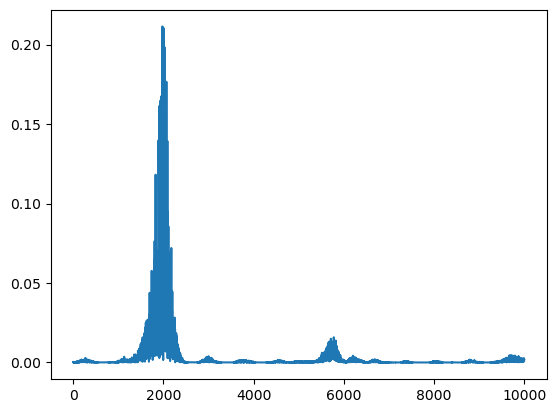

In [9]:
from scipy import fft
N = len(Final_Mode[1])
T = 1
yf = fft.fft(Final_Mode[1])
xf = fft.fftfreq(N, T/N)
amplitude = 2.0/N * np.abs(yf[:N//2])
freq = xf[:N//2]
plt.plot(freq, amplitude)

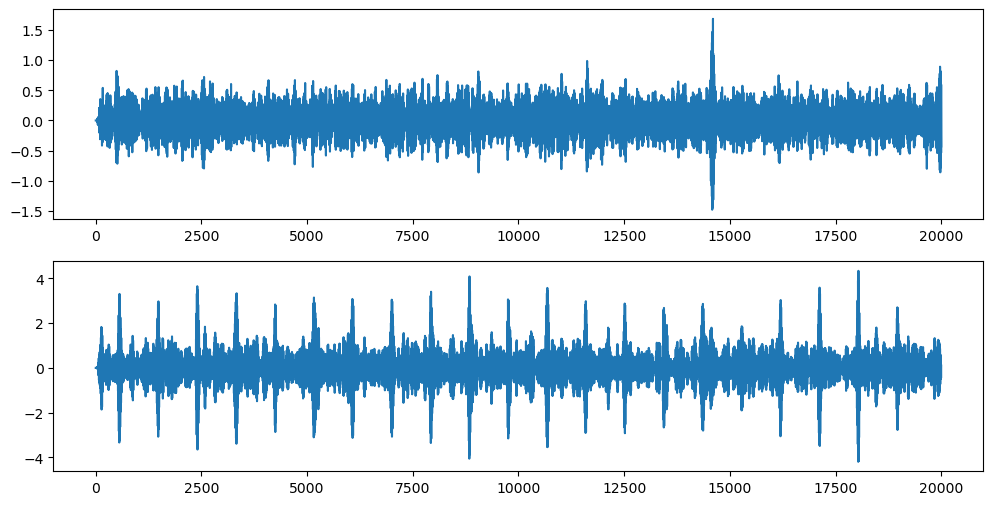

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(Final_Mode[0])
plt.subplot(212)
plt.plot(Final_Mode[1])
plt.show()  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter, correlate, find_peaks,hilbert
import pandas as pd

In [3]:
class FMD():
    def __init__(self, FilterSize=30, CutNum=7,ModeNum=2,MaxIterNum=20,fs=2e4):
        
        self.FilterSize = FilterSize+1 if FilterSize % 2 == 0 else FilterSize
        self.CutNum= CutNum
        self.ModeNum = ModeNum
        self.MaxIterNum =MaxIterNum
        self.fs = 2e4 if fs ==None else fs

    def max_IJ(self,X):
    # Returns the row and column indices of the maximum in matrix X.
        M = np.max(X)
        I, J = np.unravel_index(np.argmax(X), X.shape)
        return I, J, M
    
    def TT(self,y = None): 
        zeroposi = 0
        import math
        NA = np.correlate(y, y, mode='full')
        NA = NA[math.ceil(len(NA) / 2)-1:] 

        sample1 = NA[0]
        
        for lag in range(1,len(NA)):
            sample2 = NA[lag]
            if ((sample1 > 0) and (sample2 < 0)):
                zeroposi = lag
                break
            else:
                if ((sample1 == 0) or (sample2 == 0)):
                    zeroposi = lag
                    break
                else:
                    sample1 = sample2
                    
        NA = NA[zeroposi:]
        max_position = np.argmax(NA)
        T = zeroposi + max_position+2 #python index start from 0 
        return T
    
    def CK(self,x = None,T = None,M = 2): 
    #calculate the CK value of the signal
        x = np.array(x).flatten()
        N = len(x)

        x_shift = np.zeros((M + 1,N))
        x_shift[0,:] = x

        for m in range(M):
            if T < N: x_shift[m + 1,T:] = x_shift[m,:-T]
        
        # ck = sum(np.prod(x_shift) ** 2) / sum(x ** 2) ** (M + 1)
        numerator = np.sum(np.prod(x_shift, axis=0)**2)
        denominator = np.sum(x**2)**(M + 1)
        ck = numerator / denominator
        return ck
    def xxc_mckd(self,fs, x, f_init, termIter=30, T=None, M=2):

    # Parameter initialization
        xxenvelope = np.abs(hilbert(x)) - np.mean(np.abs(hilbert(x)))
        T = self.TT(xxenvelope)
        L = len(f_init)
        N = len(x)
        f=f_init

        # compute XmT, Xinv for Filter iteration
        XmT = np.zeros((L, N, M+1))
        XmT[:,:,0]=np.array(
            [
                np.concatenate(((np.zeros(i)),np.array(x[:N-i]))) for i in range(L)
                ]
            )
        for m in range(1,M+1):
            if m*T < N: 
                XmT[:,:,m] = np.array(
                    [np.concatenate(((np.zeros(i+T*m)),np.array(x[:N-i-T*m])))[:N] for i in range(L)]
                    )
            else: 
                XmT[:,:,m] = np.zeros(N)

        Xinv = np.linalg.inv(XmT[:, :, 0] @ XmT[:, :, 0].T)
        
        # process for update filter
        ck_best = 0
        ckIter = []
        f_final = []
        y_final = []

        for _ in range (termIter):

            y = (f.T@XmT[:,:,0]).T
            f_final.append(f)
            yt = np.zeros((N, M+1))
            yt[:, 0] = y
            for m in range(1, M+1):yt[T*m:,m] = y[:-T*m]

            alpha = np.zeros((N, M+1))
            for m in range(M+1):
                cols = list(range(m)) + list(range(m + 1, yt.shape[1]))
                prod = np.prod(yt[:, cols], axis=1)
                alpha[:, m] = (prod ** 2) * yt[:, m]

            beta = np.prod(yt, axis=1)
            Xalpha = np.zeros((1,L))
            for m in range(1,M+1): Xalpha = Xalpha + XmT[:, :, m] @ alpha[:, m]
            Xalpha = Xalpha.flatten()

            f = sum(y**2)/(2 * sum(beta**2))*Xinv@Xalpha
            f = f / np.sqrt(sum(f**2))

            ckIter.append(sum(np.prod(yt, axis=1)**2) / (sum(y**2)**(M + 1)))
            if ckIter[-1] > ck_best:ck_best = ckIter[-1]

            xyenvelope = np.abs(hilbert(y)) - np.mean(np.abs(hilbert(y)))
            T = self.TT(xyenvelope)
            T = round(T)
            T_final = T

            XmT = np.zeros((L, N, M+1))
            XmT[:,:,0]=np.array([np.concatenate(((np.zeros(i)),np.array(x[:N-i]))) for i in range(L)])
            for m in range(1,M+1):
                if m*T < N: 
                    XmT[:,:,m] = np.array([np.concatenate(((np.zeros(i+T*m)),np.array(x[:N-i-T*m])))[:N] for i in range(L)])
                else: 
                    XmT[:,:,m] = np.zeros(N)

            Xinv = np.linalg.inv(XmT[:, :, 0]@XmT[:, :, 0].T)

            y_final.append(lfilter(f_final[-1], 1, x))

        y_final= np.array(y_final)[(~np.isnan(np.array(y_final).sum(axis=1))).tolist()]
        f_final= np.array(f_final)[(~np.isnan(np.array(f_final).sum(axis=1))).tolist()]
        ckIter= np.array(ckIter)[(~np.isnan(np.array(ckIter))).tolist()]

        return y_final, f_final, ckIter, T_final   
    def process(self,signal_x):

        #Initialization
        FilterSize = self.FilterSize
        CutNum = self.CutNum
        ModeNum = self.ModeNum
        MaxIterNum = self.MaxIterNum
        fs = self.fs

        freq_bound = np.linspace(0, 1 - 1 / CutNum, CutNum)
        temp_filters = np.zeros((CutNum,FilterSize))
        for n in range(len(freq_bound)):        
                temp_filters[n] = firwin(FilterSize, [freq_bound[n] + np.finfo(float).eps, freq_bound[n] + 1 / CutNum - np.finfo(float).eps], window='hann')


        result = pd.DataFrame(
            [[None] * 5 for _ in range(CutNum + 1)],
            columns=['IterCount', 'Iterations', 'CorrMatrix', 'ComparedModeNum', 'StopNum']
        )
        result1 = {
            'y_Iter': [],
            'f_Iter': [],
            'k_Iter': [],
            'fft_f_Iter': [],
            'frequency': [],
            'T_Iter': []
        }

        x = signal_x
        itercount = 2
        temp_sig = np.tile(x, (CutNum,1))

        while True:
                iternum = 2
                if itercount == 2:
                    iternum = MaxIterNum - (CutNum - ModeNum) * iternum

                result1 = {
                    'y_Iter': [],
                    'f_Iter': [],
                    'k_Iter': [],
                    'fft_f_Iter': [],
                    'frequency': [],
                    'T_Iter': []
                }

                for n in range(temp_filters.shape[0]):
                    f_init = temp_filters[n]
                    y_Iter, f_Iter, k_Iter, T_Iter = self.xxc_mckd(fs, temp_sig[n], f_init, iternum, [], 2)

                    if len(y_Iter)!=0:
                        result1['y_Iter'].append(y_Iter[-1])
                        result1['f_Iter'].append(f_Iter[-1])
                        result1['T_Iter'].append(T_Iter)
                    
                if result1["y_Iter"].__len__() == 0:break
                temp_sig = np.array(result1["y_Iter"])
                temp_filters = np.array(result1["f_Iter"])

                CorrMatrix = np.abs(np.corrcoef(temp_sig))
                CorrMatrix = np.triu(CorrMatrix, 1)
                I,J,_ = self.max_IJ(CorrMatrix)

                x_i = result1["y_Iter"][I]
                x_j = result1["y_Iter"][J]
                x_i = x_i-np.mean(x_i)
                x_j = x_j-np.mean(x_j)

                t_1 = result1["T_Iter"][I]
                KI = self.CK(x_i, t_1, 2)
                t_2 = result1["T_Iter"][J]
                KJ = self.CK(x_j, t_2, 2)

                output = J if KI > KJ else I

                temp_sig[output] = None
                temp_filters[output] = None
                temp_filters=temp_filters[(~np.isnan(np.array(temp_filters).sum(axis=1))).tolist()]
                temp_sig = temp_sig[(~np.isnan(np.array(temp_sig).sum(axis=1))).tolist()]


                result.loc[itercount,:] = [itercount, None, CorrMatrix,"{},{}".format(I,J), output]

                if temp_filters.shape[0] == ModeNum-1 :break

                itercount = itercount + 1

        Final_Mode = result1["y_Iter"]
        return Final_Mode


In [6]:
fmd = FMD()
fmd.process(signal_x=signal_x)

[array([ 1.24274992e-08, -1.36062467e-07, -5.69982966e-07, ...,
        -5.36288548e-01,  5.94711571e-01, -4.31442986e-01]),
 array([ 2.21561100e-06, -8.18061171e-05,  1.36167730e-04, ...,
        -3.00158653e-01,  1.13208047e-02,  1.02259064e-01])]

In [5]:
import warnings
warnings.filterwarnings("ignore")

C:\Users\26921\AppData\Local\Temp\ipykernel_9500\3583455235.py:57: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
C:\Users\26921\AppData\Local\Temp\ipykernel_9500\3583455235.py:57: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
C:\Users\26921\AppData\Local\Temp\ipykernel_9500\3583455235.py:57: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
C:\Users\26921\AppData\Local\Temp\ipykernel_9500\3583455235.py:57: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
C:\Users\26921\AppData\Local\Temp\ipykernel_9500\3583455235.py:57: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from current font.
  plt.tight_layout()
C:\Users\26921\AppData\Local\Temp\ipykernel_9500\3583455235.py:57: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing fr

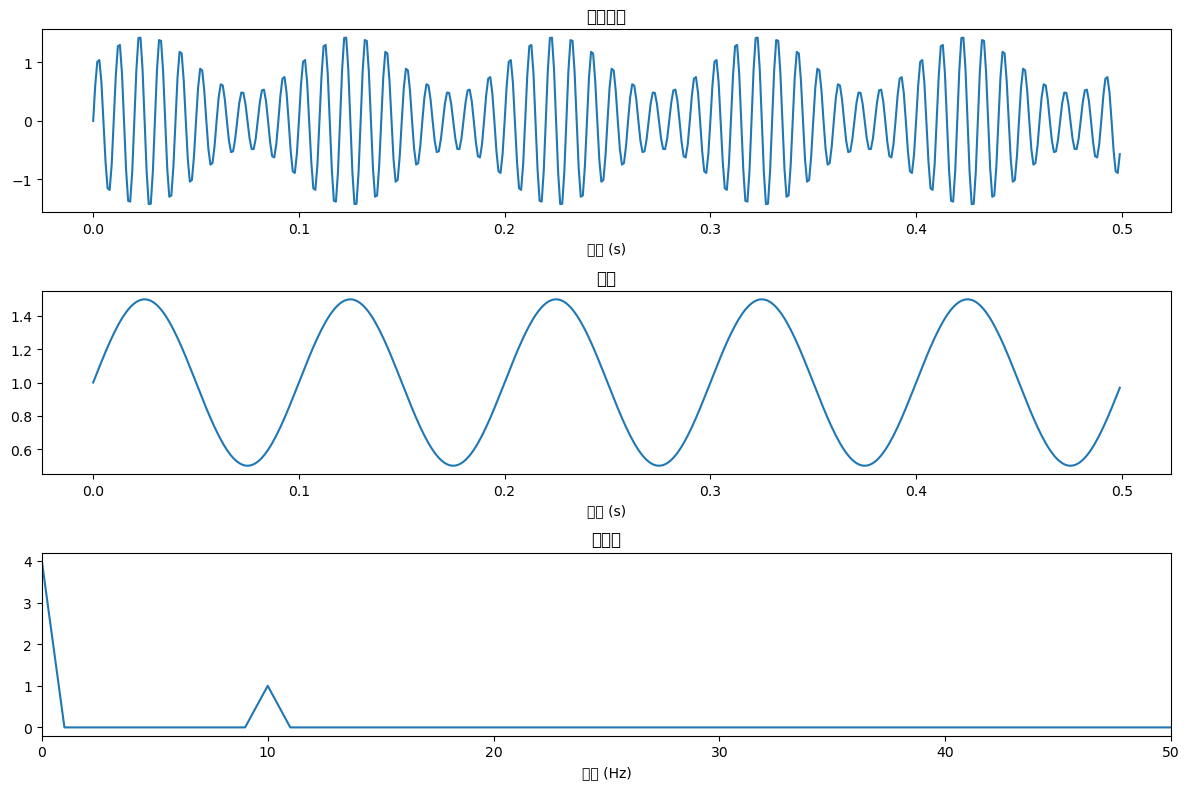

In [3]:
import numpy as np
from scipy import signal
from scipy import fft
import matplotlib.pyplot as plt

def envelope_spectrum(x, fs):
    """
    计算信号的包络谱
    x: 输入信号
    fs: 采样频率
    """
    # 计算解析信号
    analytic_signal = signal.hilbert(x)
    
    # 计算包络
    envelope = np.abs(analytic_signal)
    # envelope=np.sqrt(np.real(analytic_signal)**2+np.imag(analytic_signal)**2)
    # 计算包络的FFT
    yf = fft.fft(envelope)
    xf = fft.fftfreq(len(envelope), 1/fs)
    
    # 取半频谱
    n = len(envelope)//2
    return xf[:n], 2/n * np.abs(yf[:n])

# 生成测试信号
fs = 1000  # 采样频率
t = np.arange(0, 1, 1/fs)
fc = 100  # 载波频率
fm = 10   # 调制频率

# 生成调幅信号
x = (1 + 0.5*np.sin(2*np.pi*fm*t)) * np.sin(2*np.pi*fc*t)

# 计算包络谱
freq, amp = envelope_spectrum(x, fs)

# 绘图
plt.figure(figsize=(12, 8))

plt.subplot(311)
plt.plot(t[:500], x[:500])
plt.title('原始信号')
plt.xlabel('时间 (s)')

plt.subplot(312)
plt.plot(t[:500], np.abs(signal.hilbert(x))[:500])
plt.title('包络')
plt.xlabel('时间 (s)')

plt.subplot(313)
plt.plot(freq, amp)
plt.title('包络谱')
plt.xlabel('频率 (Hz)')
plt.xlim(0, 50)  # 限制频率范围以便观察

plt.tight_layout()
plt.show()

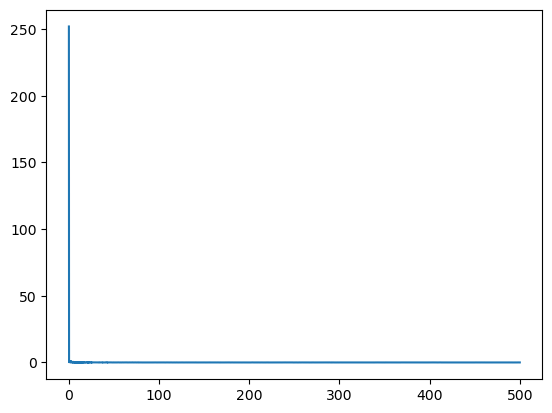

In [9]:
xf,yf=envelope_spectrum(signal_x, fs)
# amplitude = 2.0/N * np.abs(yf[:N//2])
# freq = xf[:N//2]
plt.plot(xf, yf)

对于高采样频率的信号，可以使用小波变换进行多尺度分析，提取有用的信息，同时减少信号的长度而不失真。具体步骤如下：

1. 对信号进行小波变换，获取不同尺度的细节系数和逼近系数。
2. 根据需要选择保留的系数，通常保留低频的逼近系数，因为它们包含了信号的主要特征。
3. 使用选定的系数进行逆小波变换，重构信号。

以下是一个示例代码，展示如何实现这一过程：



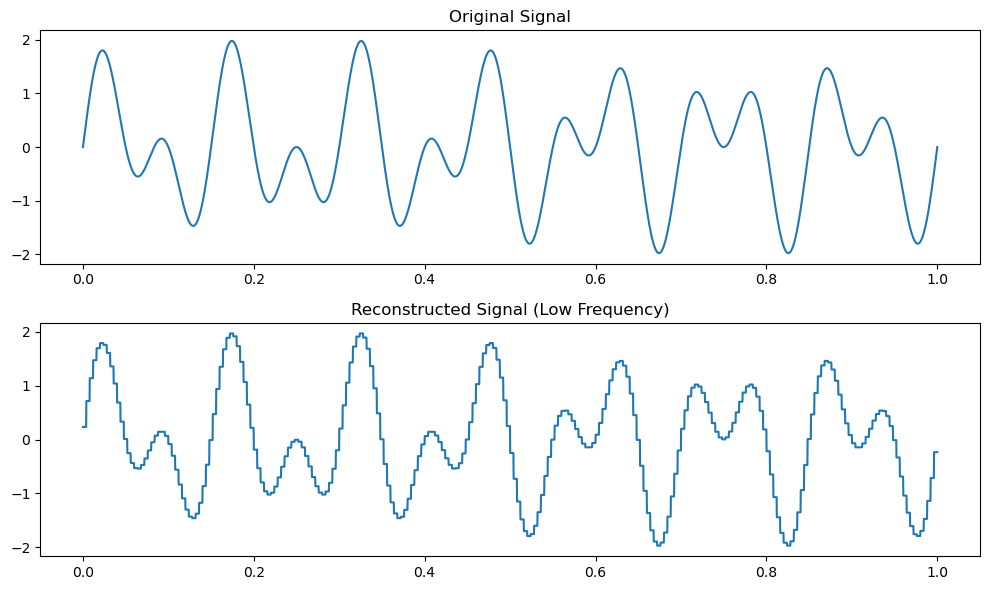

In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# 生成一个示例信号
t = np.linspace(0, 1, 4000)  # 高采样频率
signal = np.sin(2 * np.pi * 7 * t) + np.sin(2 * np.pi * 13 * t)

# 进行小波变换
wavelet = 'db1'
coeffs = pywt.wavedec(signal, wavelet, level=4)

# 只保留逼近系数（低频部分）
coeffs[1:] = [np.zeros_like(detail) for detail in coeffs[1:]]

# 使用选定的系数进行逆小波变换，重构信号
reconstructed_signal = pywt.waverec(coeffs, wavelet)

# 绘制原始信号和重构信号
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].plot(t, signal)
ax[0].set_title("Original Signal")

ax[1].plot(t, reconstructed_signal)
ax[1].set_title("Reconstructed Signal (Low Frequency)")

plt.tight_layout()
plt.show()



在这个示例中，我们生成了一个高采样频率的信号，并使用小波变换提取其低频部分。然后，我们使用这些低频系数重构信号，从而实现了信号的降采样和压缩，同时保留了主要特征。